# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from lift to grab

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random
import h5py

%matplotlib inline

In [2]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250125/beh_only/"

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/MAT_FILES/rb50_20250125_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'chan_spk', 'cue', 'cue_rec_time', 'cue_trial_time', 'depth_spk', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'lift_rec_time', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'plift', 'plift_ms', 'single', 'spikes_raw_cue', 'spikes_raw_cue_extended', 'spikes_raw_laser', 'spikes_raw_lift', 'totTime', 'trial_start']>


# Plot the patterns

In [4]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [5]:
from scipy.ndimage import zoom

In [6]:
reshape_size = 12

In [7]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [8]:
len(all_patterns)

27

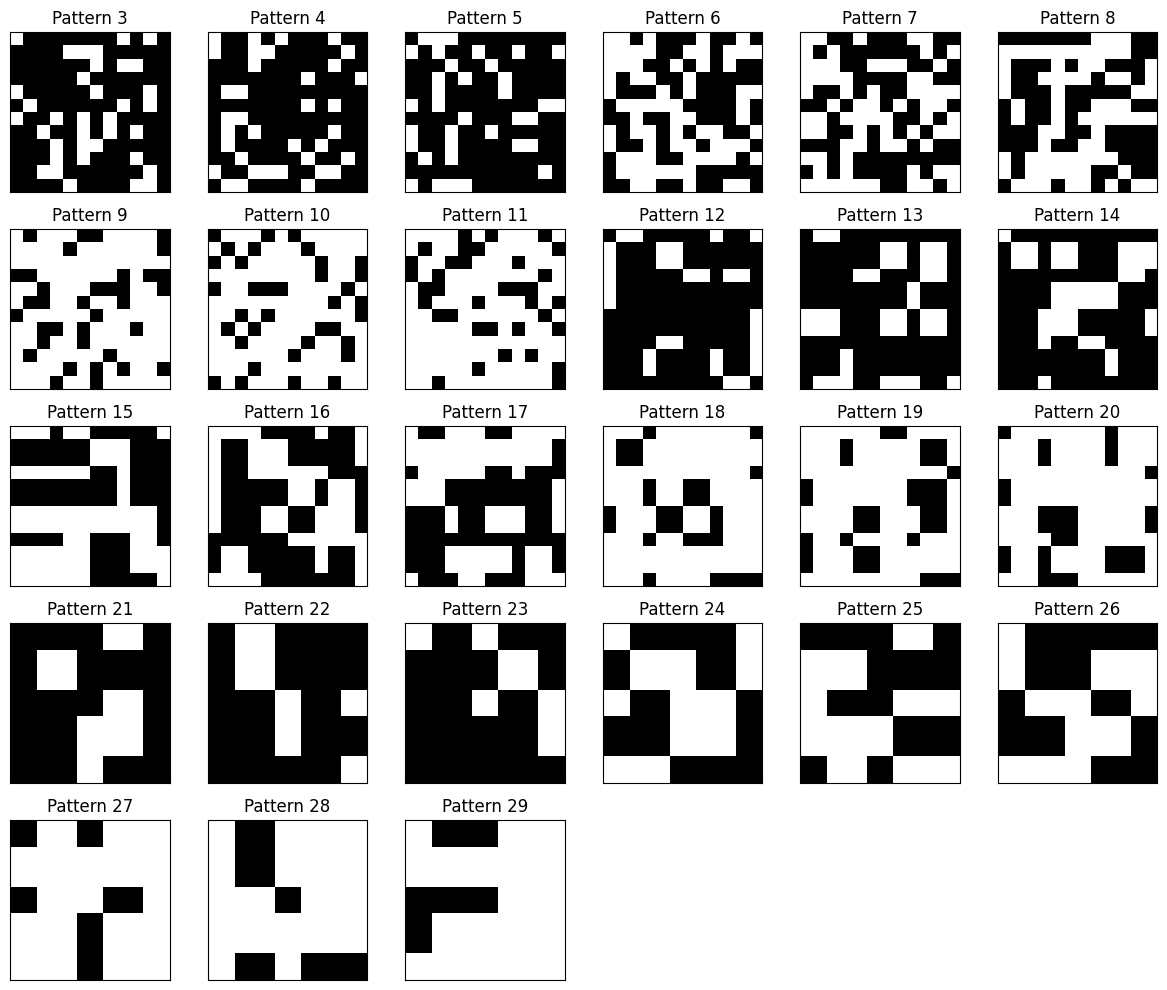

In [9]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
axes = axes.flatten()

axes[-1].remove()
axes[-3].remove()
axes[-2].remove()

for i, p in enumerate(all_patterns):
    axes[i].matshow(p, cmap="binary") 
    axes[i].set_title(f"Pattern {i+3}") 

    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()

plt.savefig(f"{path}patterns.png")

plt.show()

# Get single-reach trials

In [10]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [11]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 18,  20,  23,  32,  37,  40,  42,  48,  55,  56,  60,  61,  67,
        68,  70,  78,  83,  86,  97, 101, 103, 106, 118, 121, 128, 131])

In [12]:
behavior_idxs.shape

(26,)

## Get relevant time information

In [13]:
cue_times = data["aligned_cue_rec_time"][behavior_idxs, :]
cue_times

array([[ 410648.42872652],
       [ 444966.91347116],
       [ 496266.56795053],
       [ 650350.68137449],
       [ 736119.95814217],
       [ 787559.6107335 ],
       [ 821906.32166525],
       [ 924564.50411593],
       [1044480.64285849],
       [1061587.90028321],
       [1130010.48291324],
       [1147215.47970358],
       [1249855.53697725],
       [1266903.8875767 ],
       [1301090.49277825],
       [1437792.76679883],
       [1523578.71938072],
       [1574965.50687246],
       [1763591.68222411],
       [1832308.4213726 ],
       [1866545.72042858],
       [1917956.95802889],
       [2124034.58036439],
       [2175596.10589068],
       [2295814.14211272],
       [2347403.48288492]])

In [14]:
lift_times = data["lift_ms"][behavior_idxs, :]
lift_times

array([[310.],
       [270.],
       [200.],
       [280.],
       [350.],
       [380.],
       [320.],
       [260.],
       [280.],
       [380.],
       [290.],
       [340.],
       [260.],
       [270.],
       [290.],
       [160.],
       [330.],
       [310.],
       [350.],
       [320.],
       [280.],
       [320.],
       [330.],
       [240.],
       [260.],
       [320.]])

In [15]:
grab_times = data["mouth_ms"][behavior_idxs, :]
grab_times

array([[ 530.],
       [ 520.],
       [ 470.],
       [ 660.],
       [ 620.],
       [ 800.],
       [ 560.],
       [ 570.],
       [ 610.],
       [ 630.],
       [ 600.],
       [ 770.],
       [ 550.],
       [ 580.],
       [ 540.],
       [ 740.],
       [ 620.],
       [ 630.],
       [ 640.],
       [1440.],
       [ 570.],
       [ 610.],
       [ 650.],
       [ 510.],
       [ 500.],
       [ 560.]])

## Get the AP.bin file

In [16]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [17]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.meta")

In [18]:
meta_data = get_meta(meta_path)

In [19]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 164723792)

## Get conversion params

In [20]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [21]:
vmax

0.6

In [22]:
imax

512.0

In [23]:
gain

500.0

# Get the model data

In [24]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(range(len(idxs))):
        trial_no = i
        # get time points in ap space
        cue_time = int((cue_times[i, 0] + lift_times[i, 0] - 50) / 1_000 * 30_000)
        

       # end_behavior = int((cue_times[i, 0] + grab_times[i, 0]) / 1_000 * 30_000)
        end_behavior = int((cue_times[i, 0] + grab_times[i, 0]) / 1_000 * 30_000)

    
        trial = ap_data[:150, cue_time:end_behavior]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        m_start = cue_time - (30 * 1000)
        trial_median = ap_data[:150, m_start:cue_time]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [25]:
bin_size = 10

In [26]:
model_data = get_trials(behavior_idxs, bin_size)

100%|██████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.37it/s]


In [27]:
model_data[0].shape

(27, 150)

In [40]:
lift = int(lift_times[0, 0] / bin_size) + 5
lift

grab = int(grab_times[0, 0] / bin_size) - 1 - lift + 10

In [41]:
lift

36

In [42]:
grab

26

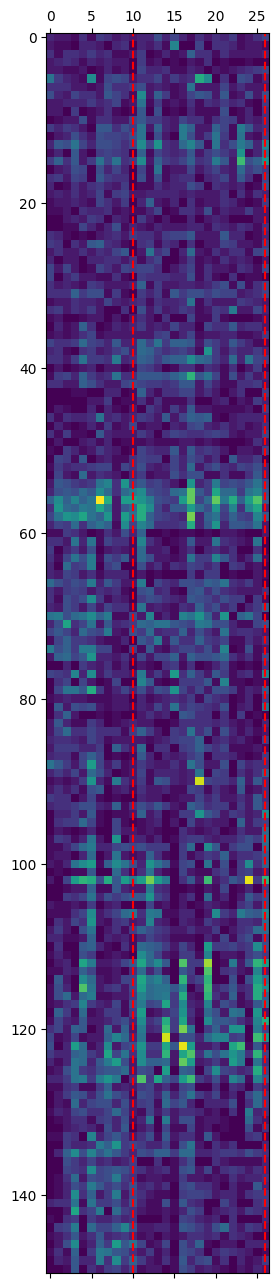

In [43]:
plt.matshow(model_data[0].T)
# plt.axvline(10-1, c="red", linestyle="--", lw=1)
plt.axvline(10, c="red", linestyle="--")
plt.axvline(grab, c="red", linestyle="--")

In [44]:
p_ids = np.unique(data["pattern_id"][0, behavior_idxs])

p_ids

array([14., 17., 20.])

In [45]:
p_ids.shape

(3,)

## Get colors for plotting

In [46]:
c = [
    "maroon",
    "deeppink",
    "palevioletred", 
    "blue", 
    "orange", 
    "green", 
    "red", 
    "purple", 
    "brown", 
    "pink",
    "turquoise", 
    "olive", 
    "cyan", 
    "gold", 
    "lime", 
    "navy", 
    "magenta",
    "teal", 
    "royalblue", 
    "darkgreen",
    "dimgray",
    "darkgoldenrod",
    "midnightblue",
    "plum",
    "lime",
    "cadetblue",
    "steelblue",
    "peru"
]

In [47]:
len(c)

28

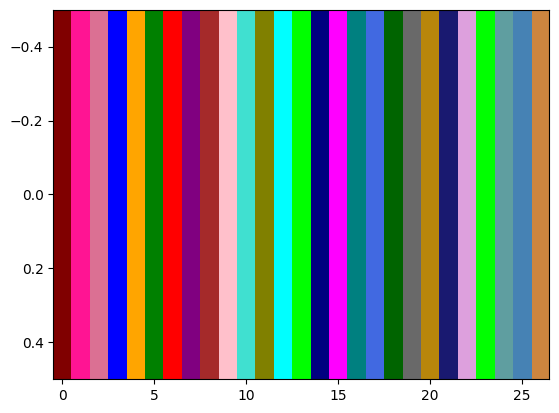

In [48]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c)

plt.imshow(np.arange(27).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

In [49]:
model_data[1].shape

(30, 150)

In [50]:
import math

In [51]:
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id])

# Fit the model

In [52]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.LDS(N=obs_dim, 
                K=1, 
                D=state_dim, 
                # M=144, 
                emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="recurrent"
               )

elbos, q = plds.fit(model_data, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [208]:
# plot my elbos

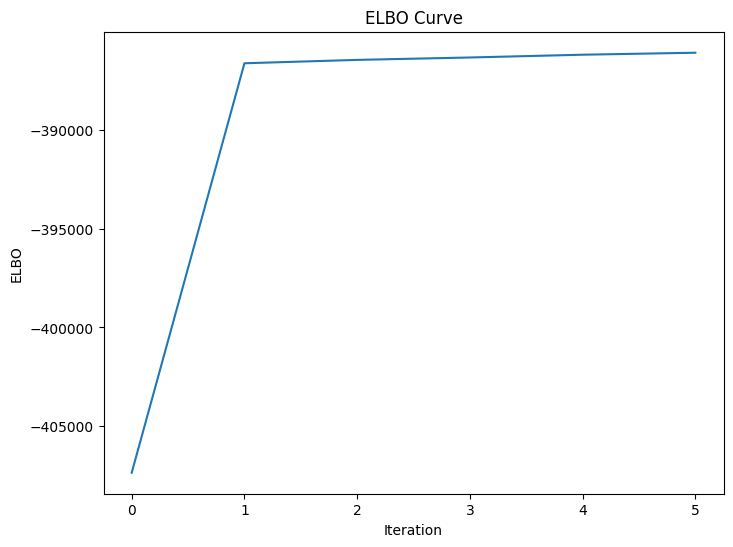

In [53]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [54]:
As = plds.dynamics.As
As.shape

(1, 3, 3)

In [55]:
b = plds.dynamics.b
b.shape

(3,)

In [57]:
As

array([[[ 0.08026698,  0.02732238, -0.01208157],
        [ 0.01787631,  0.06170925,  0.03552808],
        [-0.04829114,  0.0579734 , -0.01206461]]])

# Eigenvalue Decomposition on `A`

[-0.04241233  0.08869926  0.08362469]


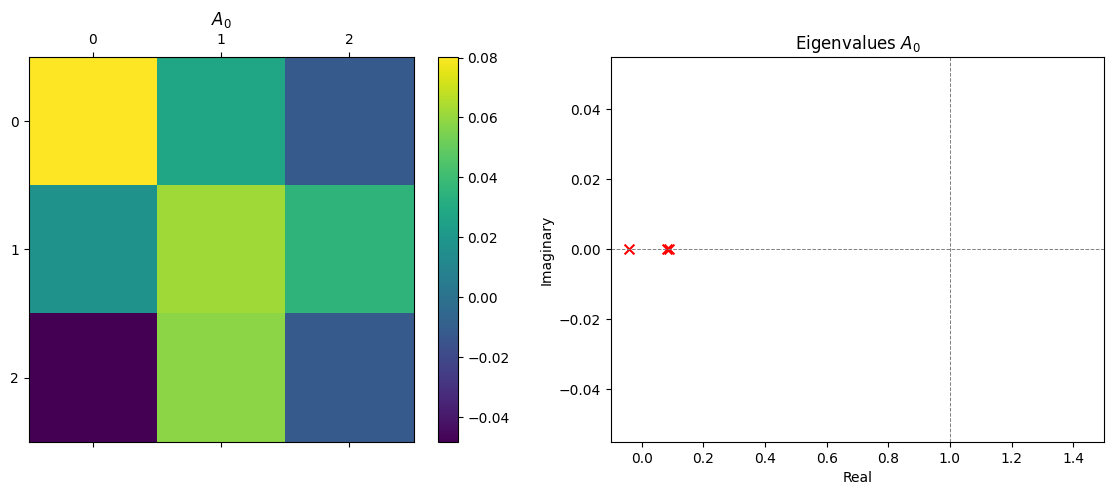

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

vmin = min(mat.min() for mat in [As[0]])
vmax = max(mat.max() for mat in [As[0]])

for i in range(1):
    ax = axes[i]
    im = ax.matshow(As[0], vmin=vmin, vmax=vmax)
    ax.set_title(f"$A_{i}$")

    eigvals, eigvecs = np.linalg.eig(As[i])
    axes[i+1].axhline(0, color='gray', linestyle='--', linewidth=0.7)
    axes[i+1].axvline(1, color='gray', linestyle='--', linewidth=0.7)

    print(eigvals.real)
    #ax.colorbar()

    axes[i+1].scatter(eigvals.real, eigvals.imag, c='red', s=50, marker="x")

    axes[i+1].set_xlim((-0.10, 1.5))
    
    axes[i+1].set_title(f"Eigenvalues $A_{i}$")
    
    axes[i+1].set_xlabel("Real")
    axes[i+1].set_ylabel("Imaginary")


fig.colorbar(im, ax=axes[0]) 

plt.savefig(f"{path}A.png")

plt.show()

# Plot the dynamics 

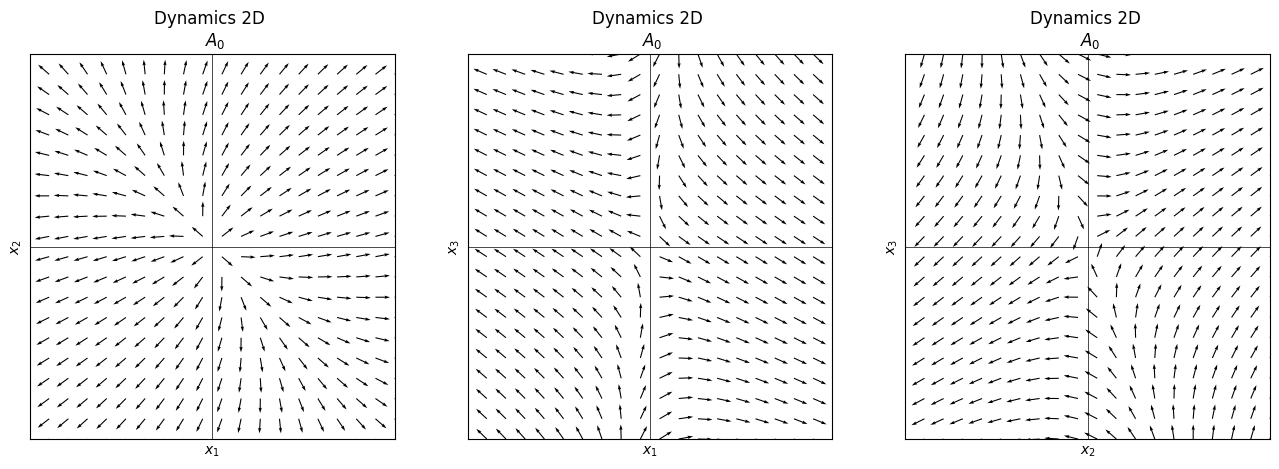

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes = axes.flatten()


A = As[0]

ax = axes[0]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")


A = As[0][[0, 2], :][:, [0, 2]]
ax = axes[1]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 
# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_3$")


A = As[0][[1, 2], :][:, [1, 2]]
ax = axes[2]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y 
V = A[1,0]*X + A[1,1]*Y

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")





plt.savefig(f"{path}dynamics2.png")
plt.show()

In [61]:
from matplotlib.patches import Patch

In [62]:
state_means = q.mean_continuous_states

In [63]:
custom_patches = [Patch(facecolor=c[int(i)-3], edgecolor='black', label=f'{int(i)}') for i in p_ids]

# Plot the state means 

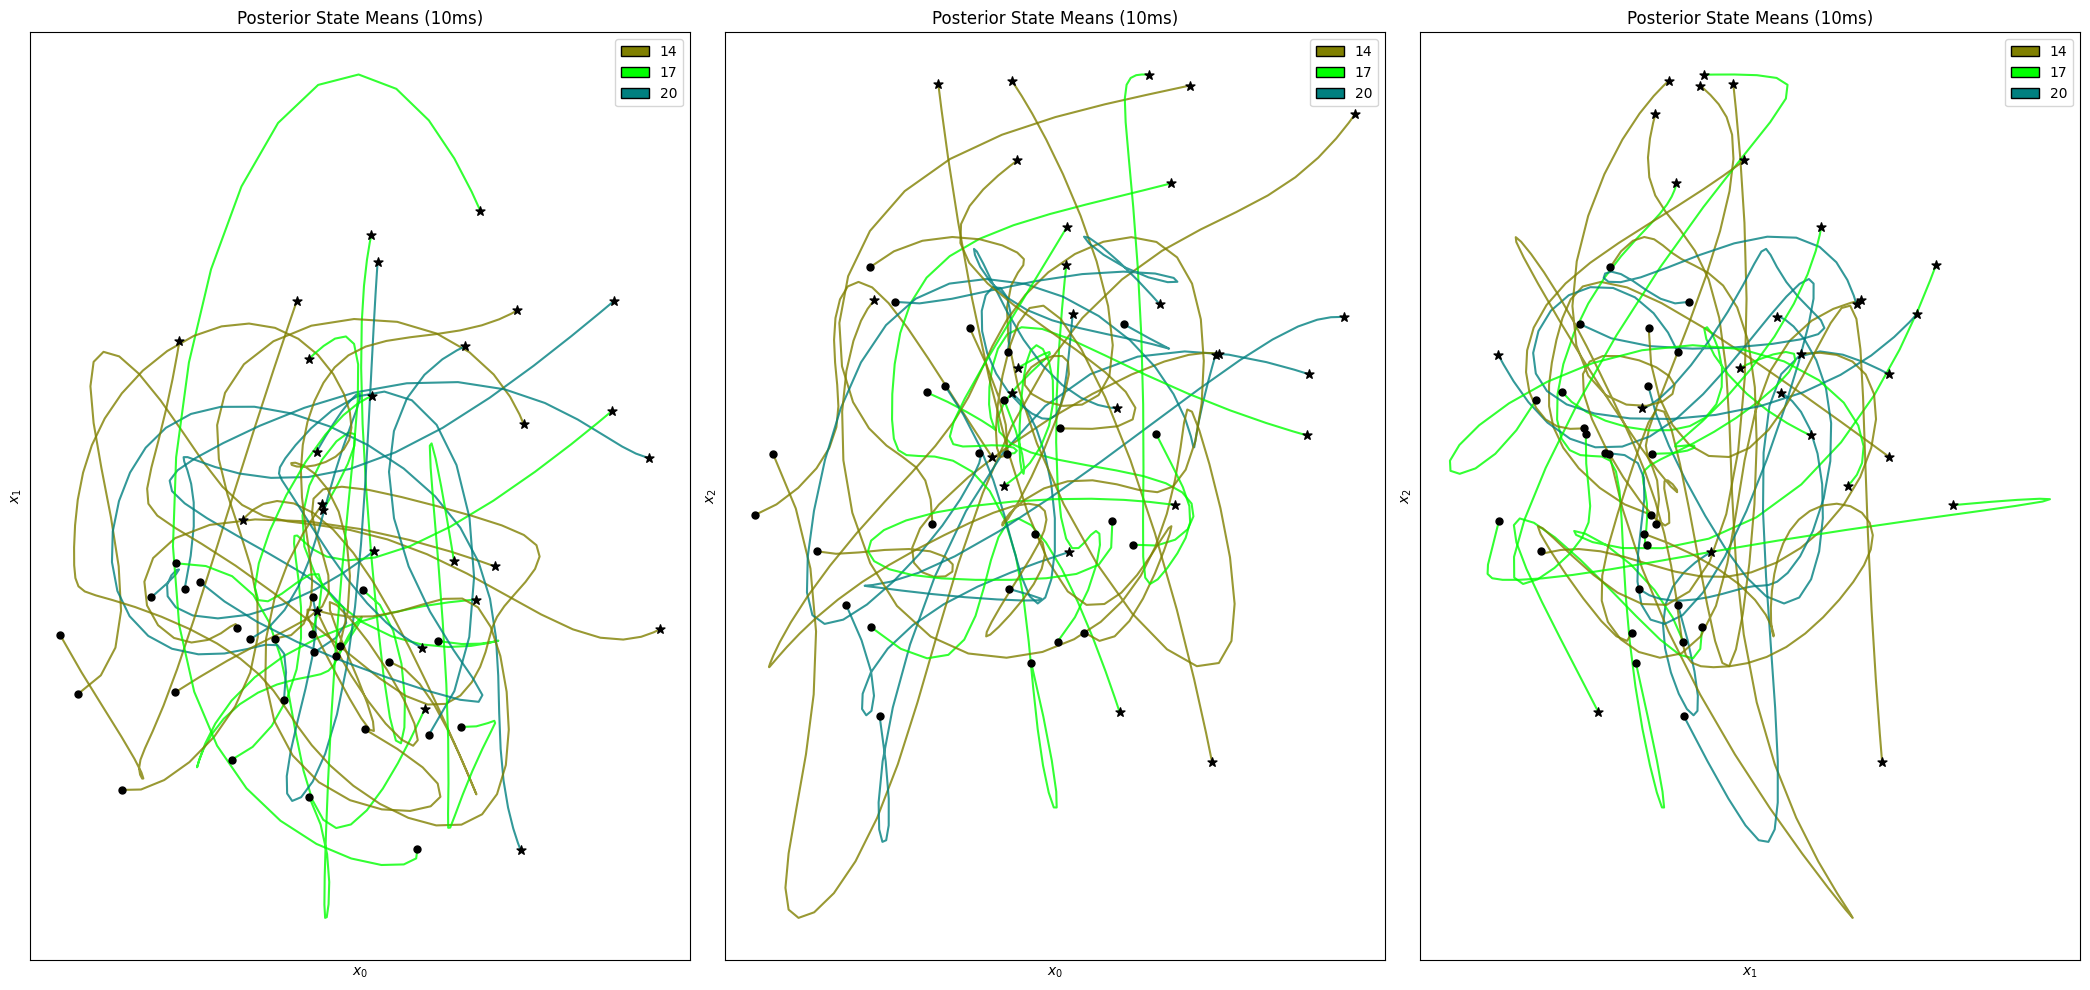

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    lift = int(lift_times[i, 0] / bin_size)
    grab = int(grab_times[i, 0] / bin_size) - 1 - lift + 20
    lift = 10

    p = gaussian_filter1d(p, 4, axis=0)

    axes[0].plot(p[lift:grab+1, 0], p[lift:grab+1, 1], c=colors[i], zorder=0, alpha=0.8)

    axes[0].scatter(p[10, 0], p[10, 1], s=25, marker='o', c="black", zorder=1, alpha=1)
    # axes[0].scatter(p[lift, 0], p[lift, 1], s=25, marker='s', c="black", zorder=1, alpha=1, label="lift")
    axes[0].scatter(p[-1, 0], p[-1, 1], s=45, marker='*', c="black", zorder=1, alpha=1, label="grab")

    axes[1].plot(p[lift:grab+1, 0], p[lift:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[10, 0], p[10, 2], s=25, marker='o', c="black", zorder=1, alpha=1)
    # axes[0].scatter(p[lift, 0], p[lift, 1], s=25, marker='s', c="black", zorder=1, alpha=1, label="lift")
    axes[1].scatter(p[-1, 0], p[-1, 2], s=45, marker='*', c="black", zorder=1, alpha=1, label="grab")

    axes[2].plot(p[lift:grab+1, 1], p[lift:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[10, 1], p[10, 2], s=25, marker='o', c="black", zorder=1, alpha=1)
    # axes[0].scatter(p[lift, 0], p[lift, 1], s=25, marker='s', c="black", zorder=1, alpha=1, label="lift")
    axes[2].scatter(p[-1, 1], p[-1, 2], s=45, marker='*', c="black", zorder=1, alpha=1, label="grab")

    # axes[2].scatter(p[0, 1], p[0, 2], s=25, marker='o', c="black", zorder=1, alpha=1)
    # axes[2].scatter(p[lift, 1], p[lift, 2], s=25, marker='s', c="black", zorder=1, alpha=1)
    # axes[2].scatter(p[grab, 1], p[grab, 2], s=45, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel(f"$x_0$")
axes[0].set_ylabel(f"$x_1$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel(f"$x_0$")
axes[1].set_ylabel(f"$x_2$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel(f"$x_1$")
axes[2].set_ylabel(f"$x_2$")

plt.savefig(f"{path}state_means_all.png")

plt.tight_layout()